# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Import Python Packages

In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import datetime
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import setuptools.dist
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Set Project Location and Batch Size

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
project_folder='/content/drive/MyDrive/Project_data'

In [79]:
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

### Utility function to resize the images

In [80]:
def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

### Generator Function

In [81]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [82]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train'
val_path = project_folder + '/' + 'val'
num_train_sequences = len(train_doc)
print('No. of training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('No. of validation sequences =', num_val_sequences)
num_epochs = 25# choose the number of epochs
print ('No. of epochs =', num_epochs)

No. of training sequences = 663
No. of validation sequences = 100
No. of epochs = 25


## Utility Functions

### Train and val generator python function

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [83]:
def create_train_val_generator(batch_size):
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    return train_generator, val_generator

### Save model python function

In [84]:
def save_model(name):

    model_name = name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    return callbacks_list

### Python function to decide the number of next() calls to be made

The **steps_per_epoch** and **validation_steps** are used by **fit_generator** to decide the number of next() calls it need to make.

In [85]:
def num_next_call():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

### Fit the model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [86]:
def fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list):
    fitted_model = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return fitted_model

### Plot accuracy and loss for the model

Create a function to plot accuracy and loss for the fitted model.

In [87]:
def plot_accuracy_loss(fitted_model):
    display(Markdown("**Training Accuracy:** " + str(round(fitted_model.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(fitted_model.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    acc = fitted_model.history['categorical_accuracy']
    val_acc = fitted_model.history['val_categorical_accuracy']

    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Experiment 1

In [88]:
# Parameters used:
total_frames = 30
num_frames = 15
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video
image_height = 100
image_width = 100
gestures = 5

In [89]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [90]:
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_19 (Conv3D)                   │ (None, 15, 100, 100, 8)     │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 15, 100, 100, 8)     │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 15, 100, 100, 8)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 7, 50, 50, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_20 (Conv3D)                   │ (None, 7, 50, 50, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 7, 50, 50, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 3, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 3, 25, 25, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 3, 25, 25, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_21 (MaxPooling3D)      │ (None, 1, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,669 (1.21 MB)

 Trainable params: 317,557 (1.21 MB)

 Non-trainable params: 112 (448.00 B)

None


In [91]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [92]:
# Let us save the model
callbacks_list = save_model('model_1')

In [93]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [94]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2148 - loss: 2.1689 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.61870, saving model to model_1_2024-11-1805_35_13.374244/model-00001-1.84364-0.20814-1.61870-0.23000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 1545s 19s/step - categorical_accuracy: 0.2148 - loss: 2.1651 - val_categorical_accuracy: 0.2300 - val_loss: 1.6187 - learning_rate: 0.0010
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2005 - loss: 1.5994
Epoch 2: val_loss improved from 1.61870 to 1.53138, saving model to model_1_2024-11-1805_35_13.374244/model-00002-1.59839-0.22031-1.53138-0.21154.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - categorical_accuracy: 0.2008 - loss: 1.5993 - val_categorical_accuracy: 0.2115 - val_loss: 1.5314 - learning_rate: 0.0010
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━

**Training Accuracy:** 0.32%

**Validation Accuracy:** 0.46%

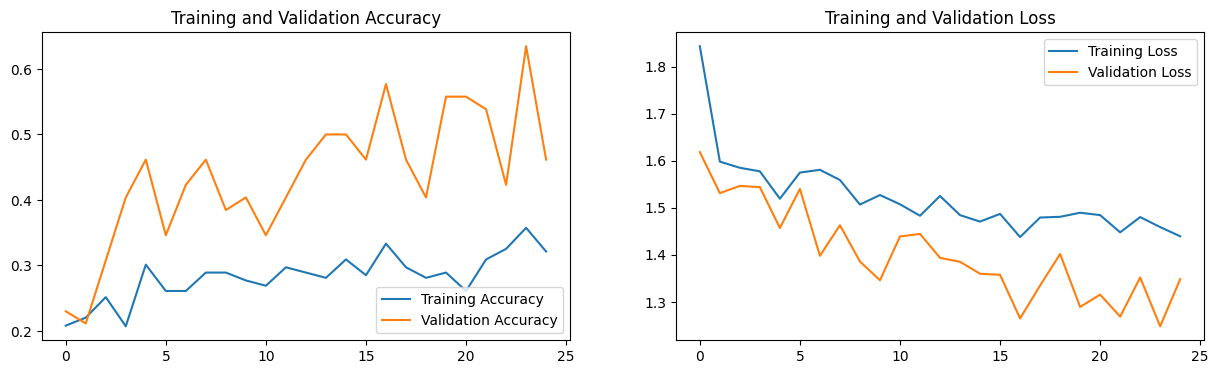

In [95]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

**Insights:**
From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters

### Experiment 2

Changing the optimizer from SGD to Adam and image height and width from 100 to 50 and batch size from 8 to 4

In [96]:
#Parameters Used:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

In [97]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_22 (Conv3D)                   │ (None, 15, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 15, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 15, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_22 (MaxPooling3D)      │ (None, 7, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 7, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 7, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 7, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_23 (MaxPooling3D)      │ (None, 3, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 3, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 3, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 3, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [98]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [99]:
# Let us save the model
callbacks_list = save_model('model_2')

In [100]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [102]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - categorical_accuracy: 0.3730 - loss: 1.4824
Epoch 1: val_loss improved from 1.45745 to 1.42028, saving model to model_2_2024-11-1805_35_13.374244/model-00001-1.49594-0.34137-1.42028-0.47000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - categorical_accuracy: 0.3728 - loss: 1.4825 - val_categorical_accuracy: 0.4700 - val_loss: 1.4203 - learning_rate: 1.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - categorical_accuracy: 0.3160 - loss: 1.4762
Epoch 2: val_loss improved from 1.42028 to 1.35524, saving model to model_2_2024-11-1805_35_13.374244/model-00002-1.48488-0.33735-1.35524-0.47000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - categorical_accuracy: 0.3161 - loss: 1.4762 - val_categorical_accuracy: 0.4700 - val_loss: 1.3552 - learning_rate: 1.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - categorical_accuracy: 0.4304 - loss: 1.3914
Epoch 3: val_loss improved from 1.35524 to 1.33418, savi

**Training Accuracy:** 0.53%

**Validation Accuracy:** 0.73%

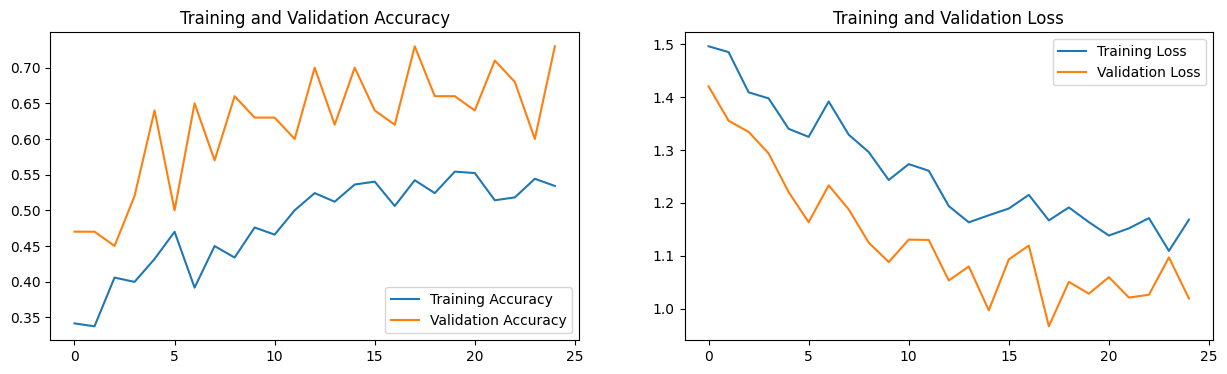

In [103]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

**Insights:**
Since the accuracy has been constantly improving we might need to increase the number of epochs in a later experiment

### Experiment 3

Reducing the dropout rate from 0.5 to 0.25 and number of frames from 15 to 10

In [104]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

In [105]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_25 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_26 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_26 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_27 (Conv3D)                   │ (None, 2, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_27 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [106]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [107]:
# Let us save the model
callbacks_list = save_model('model_3')

In [108]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [109]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - categorical_accuracy: 0.2057 - loss: 1.9843Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.49503, saving model to model_3_2024-11-1805_35_13.374244/model-00001-1.72145-0.25189-1.49503-0.43000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 155s 917ms/step - categorical_accuracy: 0.2060 - loss: 1.9827 - val_categorical_accuracy: 0.4300 - val_loss: 1.4950 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - categorical_accuracy: 0.3384 - loss: 1.4804
Epoch 2: val_loss improved from 1.49503 to 1.37262, saving model to model_3_2024-11-1805_35_13.374244/model-00002-1.46572-0.37149-1.37262-0.44000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 111s 668ms/step - categorical_accuracy: 0.3386 - loss: 1.4803 - val_categorical_accuracy: 0.4400 - val_loss: 1.3726 - learning_rate: 2.0000e-04
Epoch 3/

**Training Accuracy:** 0.83%

**Validation Accuracy:** 0.79%

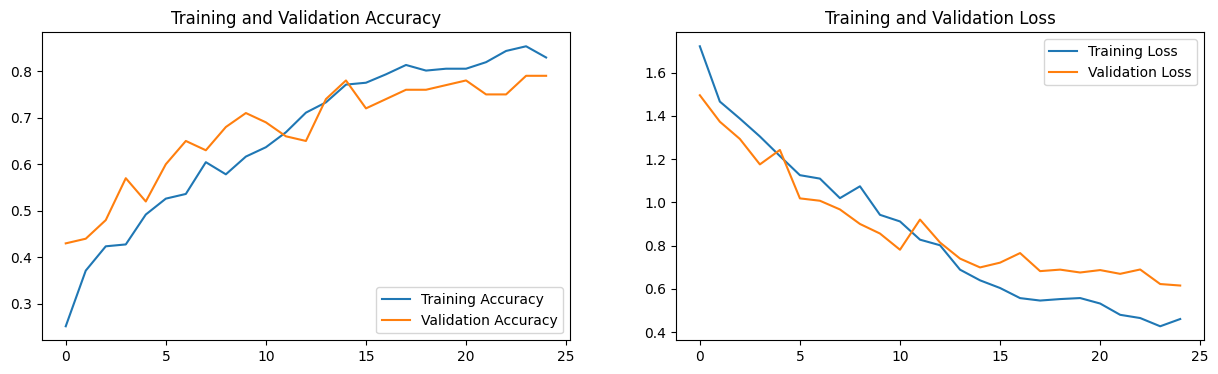

In [110]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

**Insights:**
A drop out rate of 0.25 gives up a better training and validation accuracy

### Experiment 4

Increasing the number of epochs from 25 to 35

In [111]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=35

In [112]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_28 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_29 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_29 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_30 (Conv3D)                   │ (None, 2, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_30 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [113]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [114]:
# Let us save the model
callbacks_list = save_model('model_4')

In [115]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [116]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - categorical_accuracy: 0.2287 - loss: 1.8390Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.53303, saving model to model_4_2024-11-1805_35_13.374244/model-00001-1.71545-0.22323-1.53303-0.35000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 144s 845ms/step - categorical_accuracy: 0.2287 - loss: 1.8383 - val_categorical_accuracy: 0.3500 - val_loss: 1.5330 - learning_rate: 2.0000e-04
Epoch 2/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - categorical_accuracy: 0.3105 - loss: 1.5352
Epoch 2: val_loss improved from 1.53303 to 1.43642, saving model to model_4_2024-11-1805_35_13.374244/model-00002-1.50379-0.33534-1.43642-0.33000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 112s 675ms/step - categorical_accuracy: 0.3106 - loss: 1.5350 - val_categorical_accuracy: 0.3300 - val_loss: 1.4364 - learning_rate: 2.0000e-04
Epoch 3/

**Training Accuracy:** 0.85%

**Validation Accuracy:** 0.71%

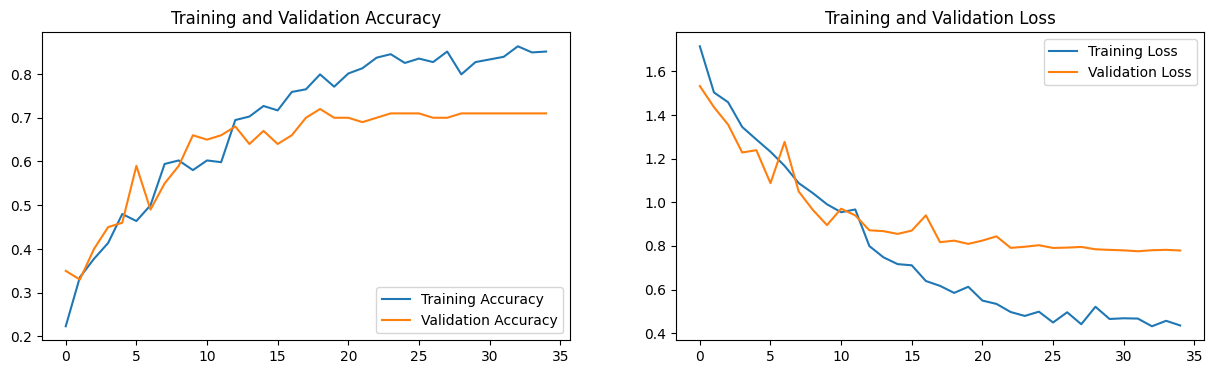

In [117]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

**Insights:**
After 35 epochs the training and validation accuracy changes to 85% and 71% respectively

### Experiment 5

In [118]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 20
num_epochs=25

In [119]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(2,2,2), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_31 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_31 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_32 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_32 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_33 (Conv3D)                   │ (None, 2, 12, 12, 32)       │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_33 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,869 (327.61 KB)

 Trainable params: 83,757 (327.18 KB)

 Non-trainable params: 112 (448.00 B)

None


In [121]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [122]:
# Let us save the model
callbacks_list = save_model('model_5')

In [123]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [124]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1940 - loss: 2.2331Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.58340, saving model to model_5_2024-11-1805_35_13.374244/model-00001-1.95924-0.22474-1.58340-0.27000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - categorical_accuracy: 0.1949 - loss: 2.2253 - val_categorical_accuracy: 0.2700 - val_loss: 1.5834 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - categorical_accuracy: 0.3201 - loss: 1.5704
Epoch 2: val_loss improved from 1.58340 to 1.54571, saving model to model_5_2024-11-1805_35_13.374244/model-00002-1.56825-0.30392-1.54571-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - categorical_accuracy: 0.3196 - loss: 1.5704 - val_categorical_accuracy: 0.2400 - val_loss: 1.5457 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━

**Training Accuracy:** 0.51%

**Validation Accuracy:** 0.43%

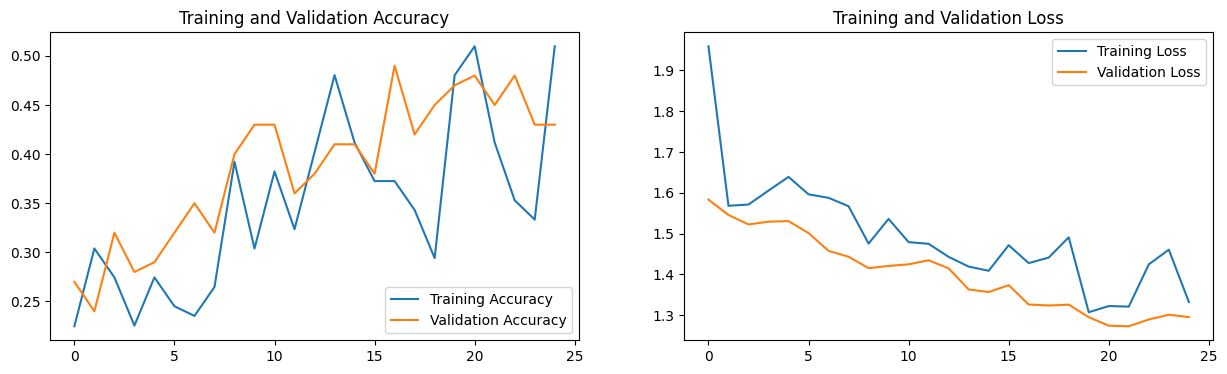

In [125]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

### Experiment 6

In [126]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 10
num_epochs=25

In [127]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_34 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_34 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_35 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_35 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_36 (Conv3D)                   │ (None, 2, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_36 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [128]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [129]:
# Let us save the model
callbacks_list = save_model('model_6')

In [130]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [131]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2206 - loss: 2.0332Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.57371, saving model to model_6_2024-11-1805_35_13.374244/model-00001-1.78705-0.23982-1.57371-0.27000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - categorical_accuracy: 0.2209 - loss: 2.0296 - val_categorical_accuracy: 0.2700 - val_loss: 1.5737 - learning_rate: 2.0000e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - categorical_accuracy: 0.3452 - loss: 1.5366
Epoch 2: val_loss improved from 1.57371 to 1.48077, saving model to model_6_2024-11-1805_35_13.374244/model-00002-1.54712-0.35821-1.48077-0.42000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 829ms/step - categorical_accuracy: 0.3454 - loss: 1.5367 - val_categorical_accuracy: 0.4200 - val_loss: 1.4808 - learning_rate: 2.0000e-04
Epoch 3/25
67/67 ━━━━

**Training Accuracy:** 0.65%

**Validation Accuracy:** 0.63%

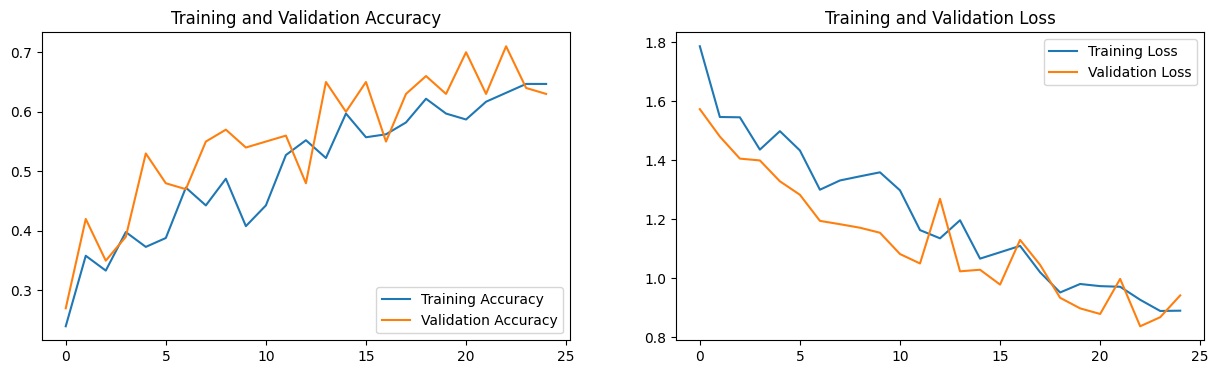

In [132]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

### Experiment 7

In [133]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 7
num_epochs=25

In [134]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_37 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_37 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_38 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_38 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_39 (Conv3D)                   │ (None, 2, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_39 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_39 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [135]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [136]:
# Let us save the model
callbacks_list = save_model('model_7')

In [137]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [138]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 7
Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2137 - loss: 1.9398Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.57170, saving model to model_7_2024-11-1805_35_13.374244/model-00001-1.73628-0.24736-1.57170-0.20000.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - categorical_accuracy: 0.2141 - loss: 1.9377 - val_categorical_accuracy: 0.2000 - val_loss: 1.5717 - learning_rate: 1.0000e-04
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - categorical_accuracy: 0.3427 - loss: 1.4592
Epoch 2: val_loss improved from 1.57170 to 1.44488, saving model to model_7_2024-11-1805_35_13.374244/model-00002-1.48607-0.33474-1.44488-0.43333.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 94s 994ms/step - categorical_accuracy: 0.3426 - loss: 1.4595 - val_categorical_accuracy: 0.4333 - val_loss: 1.4449 - learning_rate: 1.0000e-04
Epoch 3/25
95/95 ━━━━━━

**Training Accuracy:** 0.6%

**Validation Accuracy:** 0.6%

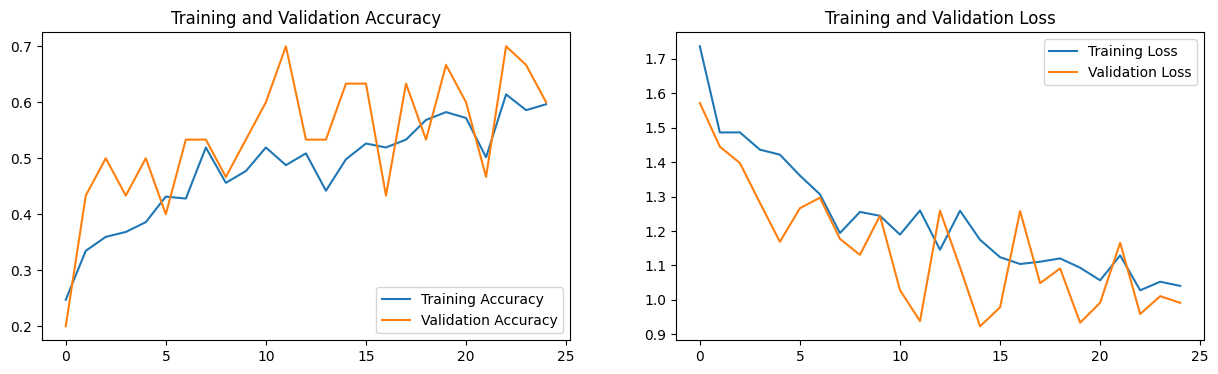

In [139]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

### Experiment 8

In [140]:
# Parameters Used:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 7
num_epochs=25

In [141]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_40 (Conv3D)                   │ (None, 10, 50, 50, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 10, 50, 50, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 10, 50, 50, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_40 (MaxPooling3D)      │ (None, 5, 25, 25, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_41 (Conv3D)                   │ (None, 5, 25, 25, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 5, 25, 25, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 5, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_41 (MaxPooling3D)      │ (None, 2, 12, 12, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_42 (Conv3D)                   │ (None, 2, 12, 12, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 2, 12, 12, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 2, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_42 (MaxPooling3D)      │ (None, 1, 6, 6, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_43 (Conv3D)                   │ (None, 1, 6, 6, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 1, 6, 6, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 1, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_43 (MaxPooling3D)      │ (None, 1, 3, 3, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 115,237 (450.14 KB)

 Trainable params: 114,997 (449.21 KB)

 Non-trainable params: 240 (960.00 B)

None


In [142]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator
train_generator, val_generator = create_train_val_generator(batch_size)

In [143]:
# Let us save the model
callbacks_list = save_model('model_8')

In [144]:
# Call num_next_call to decide on the number of next steps to be called.
steps_per_epoch, validation_steps = num_next_call()

In [145]:
# Fit the model
fitted_model = fit_model(train_generator, val_generator, steps_per_epoch, validation_steps, callbacks_list)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 7
Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2819 - loss: 1.7200Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.69783, saving model to model_8_2024-11-1805_35_13.374244/model-00001-1.58103-0.32278-1.69783-0.21000.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - categorical_accuracy: 0.2823 - loss: 1.7186 - val_categorical_accuracy: 0.2100 - val_loss: 1.6978 - learning_rate: 0.0010
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - categorical_accuracy: 0.3623 - loss: 1.3595
Epoch 2: val_loss improved from 1.69783 to 1.26451, saving model to model_8_2024-11-1805_35_13.374244/model-00002-1.30044-0.42316-1.26451-0.56667.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 977ms/step - categorical_accuracy: 0.3630 - loss: 1.3589 - val_categorical_accuracy: 0.5667 - val_loss: 1.2645 - learning_rate: 0.0010
Epoch 3/25
95/95 ━━━━━━━━━━━━━━

**Training Accuracy:** 0.76%

**Validation Accuracy:** 0.67%

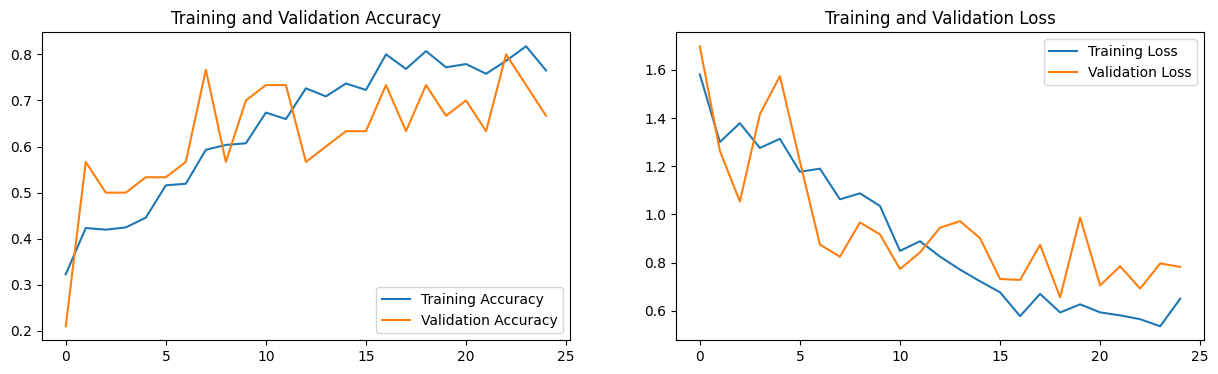

In [146]:
# Plot accuracy and loss for the model
plot_accuracy_loss(fitted_model)

## Insights

### Model 1:

**Parameters Used:**
* total_frames = 30
* num_frames = 15
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video
* image_height = 100
* image_width = 100
* gestures = 5

**Training Accuracy:** 0.32% <br>
**Validation Accuracy:** 0.46%


### Model 2
**Parameters Used:**
* total_frames = 30
* num_frames = 15
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 4

**Training Accuracy:** 0.53%<br>
**Validation Accuracy:** 0.73%

  
### Model 3
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 4

**Training Accuracy:** 0.83%<br>
**Validation Accuracy:** 0.79%

  
### Model 4
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 4
* num_epochs=35

**Training Accuracy:** 0.85%<br>
**Validation Accuracy:** 0.71%

  
### Model 5
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 20
* num_epochs=25

**Training Accuracy:** 0.51%<br>
**Validation Accuracy:** 0.43%

  
### Model 6
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 10
* num_epochs=25

**Training Accuracy:** 0.65%<br>
**Validation Accuracy:** 0.63%


### Model 7
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 7
* num_epochs=25

**Training Accuracy:** 0.6%<br>
**Validation Accuracy:** 0.6%


### Model 8
**Parameters Used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
* batch_size = 7
* num_epochs=25

**Training Accuracy:** 0.76%<br>
**Validation Accuracy:** 0.67%

## Conclusion

After doing all the experiments, we finalized **Model 3**

**Parameters used:**
* total_frames = 30
* num_frames = 10
* gestures = 5
* image_height = 50
* image_width = 50
* batch_size = 4
* filter size = (3,3,3)
* Optimizer = Adam(learning_rate=0.0002)
* Dropout(0.25)
* num_epochs=25

**Reason:**
* **Training Accuracy:** 0.83%
* **Validation Accuracy:** 0.79%
* A **drop out rate of 0.25** gives up a better training and validation accuracy
* Underfitting resolved and better accuracy score as compared to other models